# Covid19 notebook. People hostipalized in Spain.
In this notebook, I try to analyze data from covid19 in Spain. I examine the variation of people hospitalized by covid19. We use data from the Spanish government download from https://covid19.isciii.es/resources/serie_historica_acumulados.csv

In [1]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
import math
import pycountry
import argparse
from covid19_definitions import *
import datetime as dt
from typing import List

In [2]:
def plot(dates: List, value: List, 
         title: str = "", 
         file_to_save: str = None) -> None:
    """
    Plot a graph
    :param dates: x values
    :param value: y value
    :param title:
    :param file_to_save: Name file to save, None, not save
    :return:
    """
    fig, ax = plt.subplots()
    ax.set_title(title)
    ax.plot(dates, value)
    fig.autofmt_xdate()
    plt.axvline(DATE_INIT_CONFINEMENT, 
                color='r', 
                label='Confinement')
    plt.axvline(DATE_INIT_HARD_CONFINEMENT, 
                color='orange', 
                label='Hard Confinement')
    plt.legend()
    if file_to_save is not None:
        fig.savefig(file_to_save)
        
    


In [3]:
def ca_get_name(code: str) -> str:
    try:
        st = pycountry.subdivisions.get(code='ES-' + code)
        return st.name.split(',')[0].split('/')[0]
    except:
        return code

In [4]:
def get_diff_hospitalized_by_day(df: pd.DataFrame) -> List:
    return df[SZ_COLUMN_HOSPITALIZED] - df[SZ_COLUMN_HOSPITALIZED].shift(1).fillna(0)

In [5]:
def get_code(description: str) ->str:
    description_last= description.split()[-1]
    if (description_last=="Cataluña"):
        description_last = "Catalunya"
    for st in pycountry.subdivisions:
        if st.country_code=='ES':
            #print(description_last)
            #print(st.name)
            if description_last in st.name:
                #print(st.code.split("-")[1])
                if st.code.split("-")[1]=='M':
                    return 'MD'
                return st.code.split("-")[1]
    return None

## Get data 
Get panda dataframe with data about covid19 in Spain from the Spanish government.

In [6]:
r = requests.get(URL_FILE_CSV, allow_redirects=True)
open('serie_historica_acumulados.csv', 'wb').write(r.content)
df_read = pd.read_csv("serie_historica_acumulados.csv", 
                      encoding=FILE_ENCODING,
                      skipfooter=2,
                      engine='python')
df = df_read[COLUMNS_USE].copy()
df["Date"] = pd.to_datetime(df[SZ_COLUMN_DATE], format='%d/%m/%Y')
df[SZ_COLUMN_HOSPITALIZED] = df[SZ_COLUMN_HOSPITALIZED].fillna(0)
df = df.dropna()
df_ca = pd.read_csv("PopulationCA.csv", 
                    encoding=FILE_ENCODING,  
                    delimiter=';')
# Create data to all Spain (df_es) and Galician(df_ga)
df_ga=df[df[SZ_COLUMN_CA]=="GA"]
df_es=df.groupby("Date").sum()
df_es["Date"]=df_es.index

In [7]:
df_ca = pd.read_csv("PopulationCA.csv", encoding=FILE_ENCODING,  delimiter=';')
df_ca['Total'] = df_ca['Total'].str.replace('.', '')
df_ca['Total'] = pd.to_numeric(df_ca['Total'])
df_ca["Code"]=df_ca["Comunidades y Ciudades Autónomas"].apply(get_code)

In [9]:
max_date = df["Date"].max().date()
date_ago = max_date - dt.timedelta(days=5)
df_last = df[df["Date"]==max_date][
                            ["Date","Hospitalizados","CCAA"]]

df_last_week =  df[df["Date"]==date_ago][
                            ["Date","Hospitalizados","CCAA"]]
df_last_week = df_last_week.rename(columns ={"Hospitalizados" : "Hospitalizados_last_week"})
df_diff = pd.merge(df_last[["Hospitalizados","CCAA"]],
                 df_last_week[["Hospitalizados_last_week","CCAA"]], 
                 left_on='CCAA', 
                 right_on='CCAA')
df_diff["Increase"]= (df_diff["Hospitalizados"] - 
                      df_diff["Hospitalizados_last_week"])
df_diff["Increase_percent"] = (df_diff["Increase"] * 100 / 
                               df_diff["Hospitalizados_last_week"]) 
df_diff["Name"] = df_diff["CCAA"].apply(ca_get_name)
increase_sp = (df_diff["Hospitalizados"].sum()  -
               df_diff["Hospitalizados_last_week"].sum())
increase_percent_sp = increase_sp * 100 / df_diff["Hospitalizados_last_week"].sum()

In [10]:
df_ca_hospitalized_population = pd.merge(df_last[["Hospitalizados","CCAA"]],
         df_ca[["Total","Code"]], 
         left_on='CCAA', 
         right_on='Code')
df_ca_hospitalized_population["Relation"] = (df_ca_hospitalized_population["Hospitalizados"] * 10000 /
                                             df_ca_hospitalized_population["Total"])
df_ca_hospitalized_population["Name"] = df_ca_hospitalized_population["Code"].apply(ca_get_name)
hospitalized_population_sp = (df_ca_hospitalized_population["Hospitalizados"].sum() * 10000 /
               df_ca_hospitalized_population["Total"].sum())
df_ca_hospitalized_population["Relation_with_sp"] = (df_ca_hospitalized_population["Relation"] -
                                            hospitalized_population_sp)

In [11]:
print("Date from {0} to {1}".format(df["Date"].min().date(),df["Date"].max().date()))

Date from 2020-02-20 to 2020-04-13


## Plot data from Spain and Galician

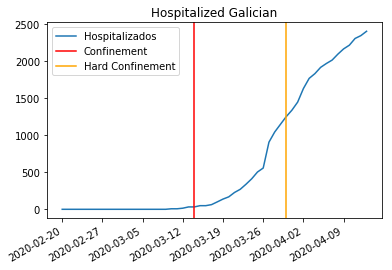

In [12]:
plot(df_ga["Date"] , 
     df_ga["Hospitalizados"], 
     title="Hospitalized Galician")

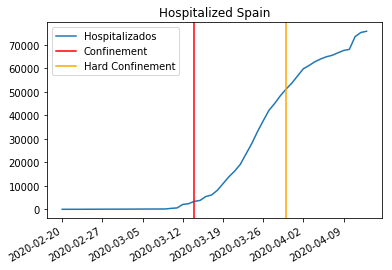

In [13]:
plot(df_es["Date"] , df_es["Hospitalizados"], title="Hospitalized Spain")

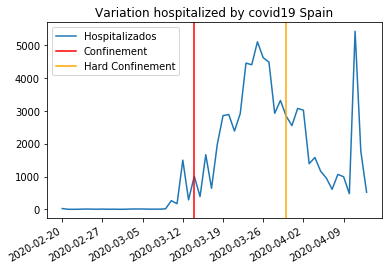

In [14]:
plot(df_es["Date"],
     get_diff_hospitalized_by_day(df_es),
     title="Variation hospitalized by covid19 Spain",
     file_to_save=FILE_VARIATION_SP)

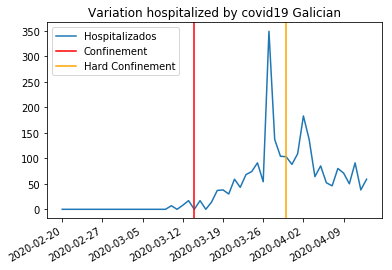

In [15]:
plot(df_ga["Date"], 
      get_diff_hospitalized_by_day(df_ga),
     title="Variation hospitalized by covid19 Galician", 
     file_to_save="VariationGalician")

## Plot data by community

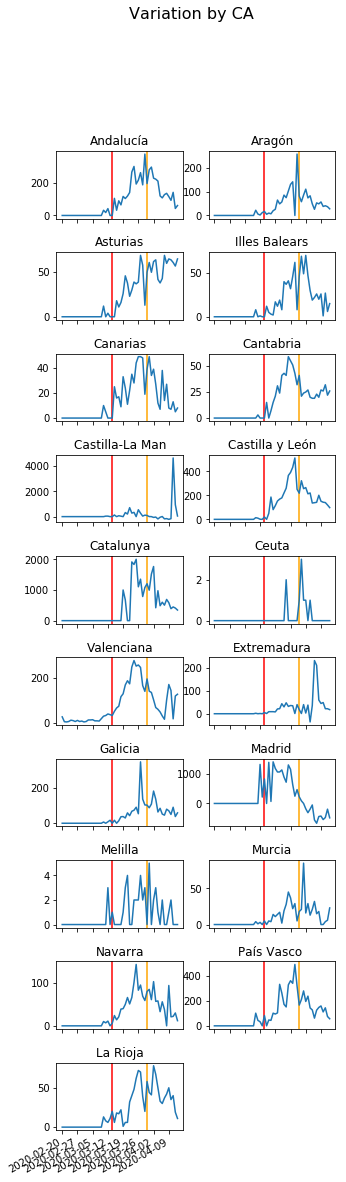

In [16]:
lst_ca=list(df[SZ_COLUMN_CA].unique())
n_columns=2
n_rows= math.ceil(len(lst_ca) /  n_columns)
fig, ax = plt.subplots( n_rows , def plot(dates: List,
         value: List,
         title: str = "",
         file_to_save: str = None) -> None:
    """
    Plot a graph
    :param dates: x values
    :param value: y value
    :param title:
    :param file_to_save: Name file to save, None, not save
    :return:
    """
    fig, ax = plt.subplots()
    ax.set_title(title)
    ax.plot(dates, value)
    fig.autofmt_xdate()
    plt.axvline(DATE_INIT_CONFINEMENT,
                color='r',
                label=LABEL_INIT_CONFINEMENT)
    plt.axvline(DATE_INIT_HARD_CONFINEMENT,
                color='orange',
                label=LABEL_INIT_HARD_CONFINEMENT)
    plt.legend()
    if file_to_save is not None:
        fig.savefig(file_to_save)


def ca_get_name(code: str) -> str:
    try:
        st = pycountry.subdivisions.get(code='ES-' + code)
        return st.name.split(',')[0].split('/')[0]
    except:
        return code
                       n_columns,
                       figsize=(5, 20))
for ca in lst_ca:
    index=lst_ca.index(ca)
    column = math.floor(index/n_columns)
    row = index - column * n_columns
    df_ca = df[df[SZ_COLUMN_CA] == ca]    
    values = get_diff_hospitalized_by_day(df_ca)
    ax[column, row].axvline(DATE_INIT_CONFINEMENT, color='r')
    ax[column, row].axvline(DATE_INIT_HARD_CONFINEMENT, color='orange')
    ax[column, row].set_title(ca_get_name(ca)[:15])
    ax[column, row].plot(df_ca["Date"], values)
plt.subplots_adjust(hspace=0.5)
fig.autofmt_xdate()
if len(lst_ca) %2 != 0:
    fig.delaxes(ax[ n_rows -1, n_columns - 1] )
    
fig.suptitle("Variation by CA", fontsize=16)
fig.savefig(FILE_VARIATION_BY_CA, format='png')


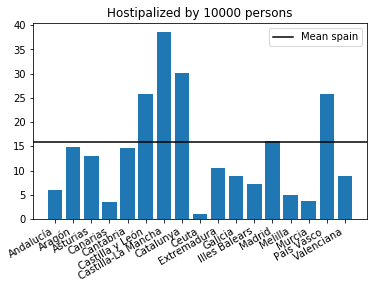

In [21]:
fig, ax = plt.subplots()
ax.set_title("Hostipalized by 10000 persons")
fig.autofmt_xdate()

ax.bar(df_ca_hospitalized_population['Name'], 
    df_ca_hospitalized_population['Relation'])
ax.axhline( y=hospitalized_population_sp, 
           color="k",
          label ="Mean spain")
plt.legend()

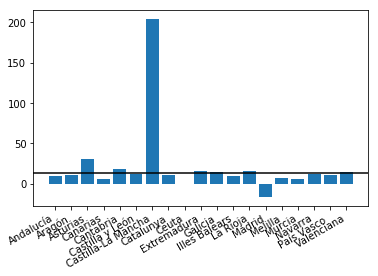

In [22]:
fig, ax = plt.subplots()
ax.set_title("")
fig.autofmt_xdate()
ax.bar(df_diff["Name"], 
   df_diff["Increase_percent"])
ax.axhline( y=increase_percent_sp, color="k")

In [24]:
df_all = pd.merge(df_diff[["Increase_percent","Increase","CCAA","Name"]],
         df_ca_hospitalized_population[["Relation_with_sp","Relation","CCAA"]], 
         left_on='CCAA', 
         right_on='CCAA')

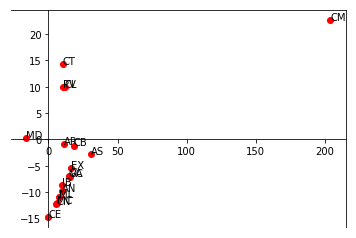

In [25]:
fig, ax = plt.subplots()
ax.plot(df_all["Increase_percent"], df_all["Relation_with_sp"], 'ro')
ax.spines['left'].set_position('zero')
ax.spines['bottom'].set_position('zero')
for index, row in df_all.iterrows():
    plt.annotate(row["CCAA"],
                 [row["Increase_percent"], row["Relation_with_sp"]])